In [233]:
import numpy as np
import scipy.io
import networkx as nx
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import json

from numpy.lib.stride_tricks import sliding_window_view
from opt_einsum import contract
from statsmodels.graphics.tsaplots import plot_acf

### Build Connectome DiGraph

In [234]:
def get_connectome(filepath, sheet_name, existing_connectome=None):
    excel_connectome = pd.read_excel(filepath, sheet_name)
    table = excel_connectome.values[1:,2:]

    neuron_names = set().union(table[1:,0], table[0,1:])
    neuron_names = {x for x in neuron_names if x == x} #remove nans
    neuron_names = sorted(list(neuron_names))

    edge_list = []

    def isnan(x):
        return isinstance(x, float) and np.isnan(x)

    for r in range(1,len(table)):
        for c in range(1,len(table[r])):
            if isnan(table[r][c]) or isnan(table[r][0]) or isnan(table[0][c]):
                continue
            edge_list.append((table[r][0], table[0][c], table[r][c]))

    connectome = existing_connectome if existing_connectome else nx.DiGraph() 
    connectome.add_nodes_from(neuron_names)
    connectome.add_weighted_edges_from(edge_list)
    return connectome

In [235]:
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male chemical")

# just take the union of all connectome data
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn symmetric", existing_connectome=CONNECTOME)
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn asymmetric", existing_connectome=CONNECTOME)

In [236]:
print(sorted(((d,n) for n,d in CONNECTOME.degree), reverse=True))

[(138, 'AVAR'), (137, 'hyp'), (132, 'AVAL'), (110, 'AVBR'), (109, 'PVV'), (106, 'EF2'), (104, 'PDB'), (100, 'PVZ'), (96, 'EF3'), (94, 'AVG'), (93, 'PVX'), (91, 'PVNL'), (90, 'AVBL'), (85, 'DVA'), (83, 'EF1'), (83, 'CA05'), (80, 'PVCR'), (78, 'HOB'), (76, 'R7BL'), (74, 'VA12'), (74, 'R1BR'), (71, 'R3BR'), (70, 'DVC'), (70, 'AVFL'), (69, 'PVCL'), (68, 'PVY'), (67, 'PVPL'), (67, 'AVFR'), (66, 'VB09'), (66, 'PQR'), (66, 'CP07'), (66, 'CP04'), (65, 'PVNR'), (65, 'CP05'), (65, 'CA06'), (65, 'AVKR'), (64, 'VB08'), (64, 'R7BR'), (64, 'HOA'), (64, 'CP09'), (64, 'AVKL'), (62, 'VB10'), (62, 'R2BR'), (61, 'PHCL'), (60, 'SPVL'), (60, 'AVDR'), (59, 'SPVR'), (59, 'R2BL'), (59, 'DVF'), (59, 'DD05'), (58, 'DD06'), (57, 'R7AR'), (57, 'R3BL'), (57, 'PHCR'), (57, 'PCAL'), (56, 'RIBR'), (56, 'R9AR'), (55, 'R5BR'), (55, 'PCBL'), (54, 'SMDVL'), (54, 'RIAR'), (54, 'PDC'), (54, 'CP06'), (53, 'SMDDL'), (53, 'RIAL'), (53, 'AVL'), (53, 'AVDL'), (52, 'R7AL'), (52, 'DA08'), (51, 'VA10'), (51, 'SMDDR'), (51, 'PVQR')

In [237]:
# nx.draw_networkx(CONNECTOME, arrows=True)

In [238]:
fake_connectome = get_connectome('datasets/fake_test_data/fake_connectome.xlsx', 'S1S2N1')

In [239]:
def get_weight(neuron1, neuron2, connectome=CONNECTOME):
    return connectome.get_edge_data(neuron1, neuron2)['weight'] if connectome.get_edge_data(neuron1, neuron2) else 0

In [240]:
class TraceObject:
    def __init__(self, json_filepath):
        with open(json_filepath) as trace_file:
            self.trace_json = json.load(trace_file)
            
        self.num_neurons = self.trace_json['num_neurons']

        self.traces = np.array(self.trace_json['trace_array'])

        self.trace_indices = {}
        for i in range(self.trace_json['num_neurons']):
            if str(i+1) in self.trace_json['labeled']:
                self.trace_indices[self.trace_json['labeled'][str(i+1)]['label']] = i  # neurons are 1-indexed

    def get_label(self, i):
        if str(i+1) not in self.trace_json['labeled']:
            return "" # empty string indicates neuron at index i is unlabeled
        return self.trace_json['labeled'][str(i+1)]['label']
    
    def get_index(self, label):
        if label not in self.trace_indices:
            return -1
        return self.trace_indices[label]
        

In [241]:
def get_relevant_neurons(neuron, connectome=CONNECTOME):
    return set().union([neuron], connectome.successors(neuron), connectome.predecessors(neuron))

def get_relevant_mask(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = get_relevant_neurons(neuron, connectome)
    return np.array([trace_obj.get_label(i) in relevant_neurons for i in range(trace_obj.num_neurons)])

def get_relevant_mask_labels(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = get_relevant_neurons(neuron, connectome)
    indices = []
    for i in range(trace_obj.num_neurons):
        label = trace_obj.get_label(i)
        if label in relevant_neurons:
            indices.append(label)
    return indices

In [242]:
w_rr = 3
w_sr = 1

In [243]:
def calculate_c(neuron, trace_obj, window_start=0, window_width=None, connectome=CONNECTOME):
    if window_width == None:
        window_width = trace_obj.traces.shape[1] - window_start
    num_windows = window_width - max(w_rr,w_sr) + 1

    traces = trace_obj.traces[:,window_start : window_start + window_width]
    
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    if self_index == -1:
        raise ValueError(f"Neuron {neuron} does not have any labeled traces in this dataset.")

    # TODO: We incur a T x relevant_count x w_rr x 1 x (w_sr+1) (about 3000x) blowup here - there is a LOT of redundancy that might be used to bring this down.
    # relevant_count x w_rr x 1 x (w_sr+1) (about 3000) is the number of entries in C
    relevant_sliding_window = np.squeeze(sliding_window_view(traces[relevant_mask,max(w_sr-w_rr,0):], (relevant_count, w_rr), writeable=False), axis=0)
    self_sliding_window = np.squeeze(sliding_window_view(traces[self_index:self_index+1,max(w_rr-w_sr,0):], (1, w_sr), writeable=False), axis=0)
    self_sliding_window = np.concatenate((self_sliding_window, np.ones((num_windows, 1, 1))), axis=2)
    A = contract("tij,tkl->tijkl", relevant_sliding_window, self_sliding_window).reshape(num_windows, relevant_count * w_rr * (w_sr + 1))
    A = A[:-1,:] # can't predict outside of observation window

    # Looking to minimize Ac - traces[neuron]
    observation = traces[self_index][max(w_rr,w_sr):]
    c = np.linalg.inv(A.T @ A) @ A.T @ observation

    plt.plot(np.arange(num_windows-1), observation)
    plt.show()

    plt.plot(np.arange(num_windows-1), A @ c)
    plt.show()

    print(np.linalg.norm(observation - A @ c))

    return c

In [244]:
def live_simulation(c, neuron, trace_obj, start=w_rr, runtime=None, connectome=CONNECTOME):
    trace_len = trace_obj.traces.shape[1]
    if runtime == None or start + runtime > trace_len:
        runtime = trace_len - start

    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    temp_traces = np.copy(trace_obj.traces) # we will overwrite the self_index row with our predicted values
    
    C = c.reshape((relevant_count,w_rr,1,w_sr+1))

    for t in range(start,start+runtime):
        relevant_history = temp_traces[relevant_mask,t-w_rr:t]
        self_history = temp_traces[self_index:self_index+1,t-w_sr:t]
        augmented_self_history = np.concatenate((self_history, np.ones((1,1))), axis=1)
        temp_traces[self_index, t] = contract("ij,ijkl,kl", relevant_history, C, augmented_self_history)

    observation = trace_obj.traces[self_index,start:start+runtime]
    plt.plot(np.arange(runtime), observation)
    plt.show()

    prediction = temp_traces[self_index,start:start+runtime]
    plt.plot(np.arange(runtime), prediction)
    plt.show()

    print(np.linalg.norm(observation - prediction))

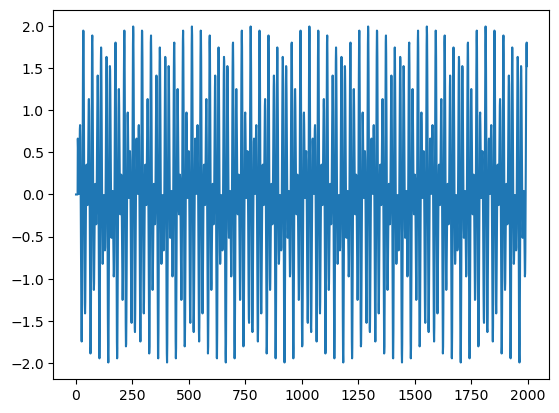

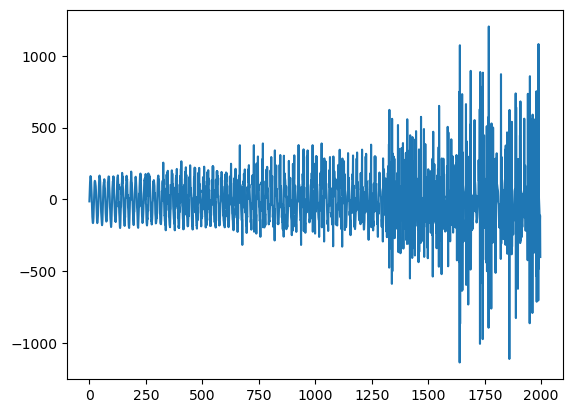

9045.459549682788


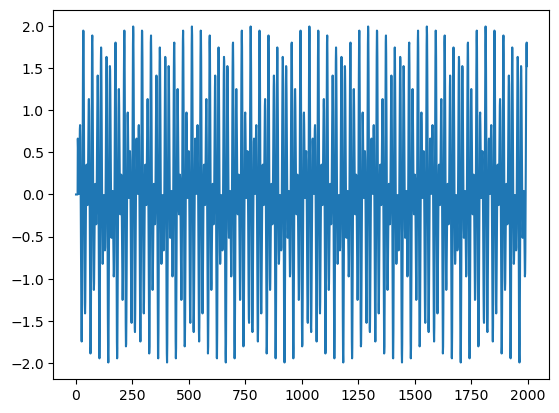

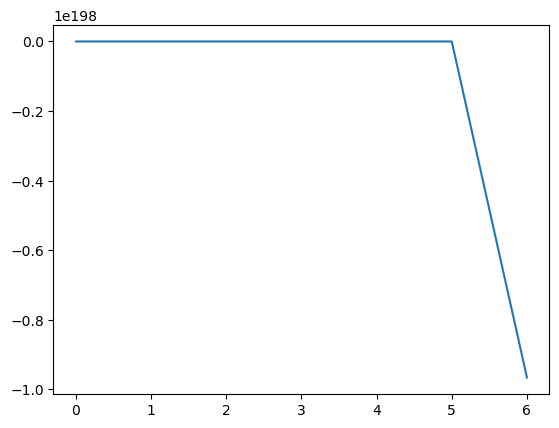

nan


In [245]:
trace_obj = TraceObject('datasets/fake_test_data/fake_traces.json')
c = calculate_c('N1', trace_obj, connectome=fake_connectome)
live_simulation(c, 'N1', trace_obj, connectome=fake_connectome)

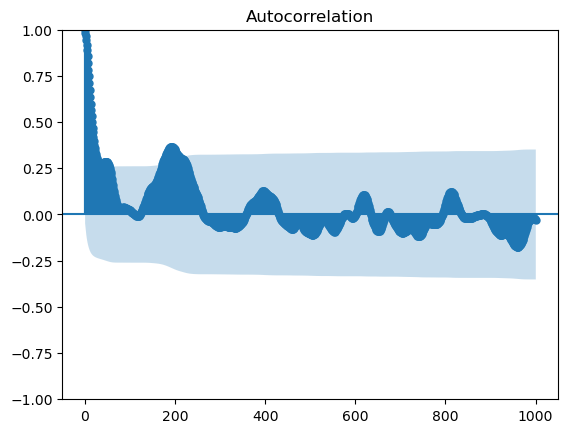

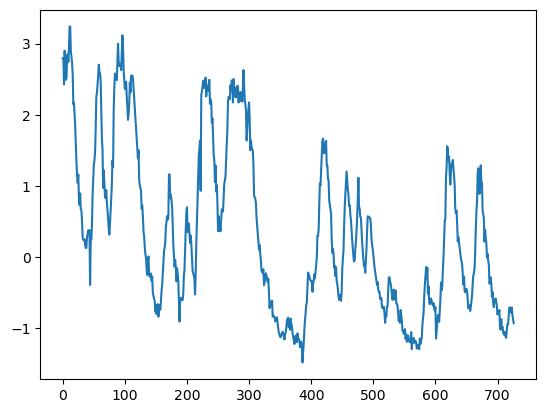

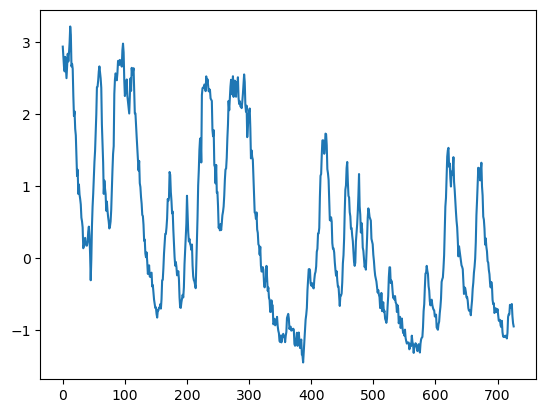

3.673837201290275


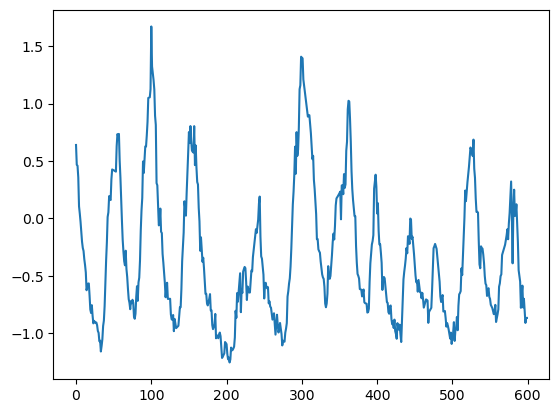

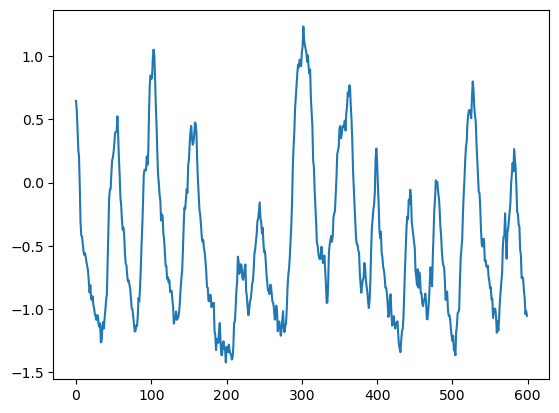

5.671137667953832
102
[-5.40870378e-03 -4.71137680e-03 -4.20145443e-04 -1.02033620e-02
  1.41865173e-02 -2.40324703e-03 -6.59728166e-03 -4.38309215e-04
 -1.68913908e-02 -5.34609862e-03  3.75774436e-03 -3.45586441e-03
 -2.45660048e-02 -5.92539888e-03  1.49403186e-02  1.45855377e-02
  6.34869056e-03 -3.09453809e-02 -1.83897398e-02 -8.51980877e-03
 -4.90075489e-02  1.24529920e-01  9.33758211e-02  5.68135282e-01
  2.50784326e-02 -3.92895531e-02 -1.65480425e-03 -3.57404913e-03
 -6.51126271e-03  7.75405792e-03  7.63779087e-02 -1.56458655e-02
 -3.91999078e-02 -5.26753764e-02 -7.05193363e-02  2.14787598e-01
 -5.04003911e-03  3.08150161e-03 -1.11327283e-02  9.33312879e-03
  3.97503666e-02  2.75318687e-02  2.65607427e-02 -2.35632777e-01
  5.25142329e-02  6.67804490e-02 -1.25853267e-01  3.70638482e-01
  1.80044170e-03  9.74629552e-03 -3.00432491e-03 -9.24485105e-03
  4.68931701e-03  4.34674030e-03  1.01274642e-02 -1.31087448e-02
  7.05413613e-03  6.72524012e-03  3.39160930e-03  7.02381284e-03
  8

In [246]:
neuron = 'AVAR'

trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
self_index = trace_obj.get_index(neuron)
if self_index == -1:
    raise ValueError(f"Neuron {neuron} does not have any labeled traces in this dataset.")

plot_acf(trace_obj.traces[self_index,:], lags=1000)
plt.show()

c = calculate_c(neuron, trace_obj, 0, 730)
live_simulation(c, neuron, trace_obj, 1000)

print(len(c))
print(c)

In [247]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90)

    # Turn spines off and create white grid.
    # ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    # ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

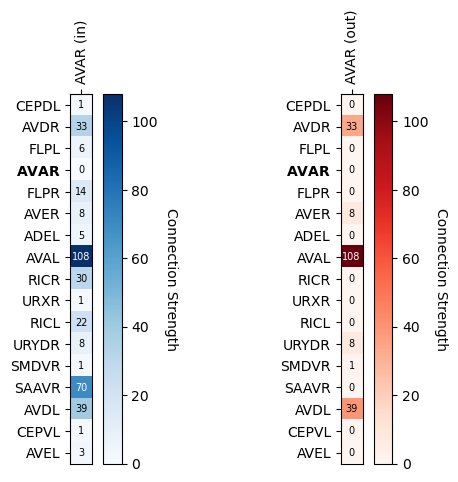

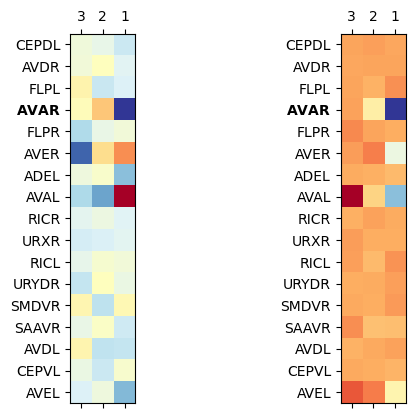

In [248]:
def visualize_c(c, neuron, trace_obj, connectome=CONNECTOME):
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)

    relevant_labels = get_relevant_mask_labels(neuron, trace_obj, connectome)
    i = relevant_labels.index(neuron)
    relevant_labels[i] = f'$\\bf{{{relevant_labels[i]}}}$'

    figure, ax = plt.subplots(1, 2)

    in_weights = np.array([[get_weight(neighbor, neuron) for neighbor in relevant_labels]]).T
    im, cbar = heatmap(in_weights, relevant_labels, [f'{neuron} (in)'], ax[0], cmap=plt.cm.Blues, cbarlabel='Connection Strength')
    texts = annotate_heatmap(im, valfmt='{x}', size=7)

    out_weights = np.array([[get_weight(neuron, neighbor) for neighbor in relevant_labels]]).T
    im, cbar = heatmap(out_weights, relevant_labels, [f'{neuron} (out)'], ax[1], cmap=plt.cm.Reds, cbarlabel='Connection Strength')
    texts = annotate_heatmap(im, valfmt='{x}', size=7)

    figure.show()

    C = c.reshape((relevant_count,w_rr,1,w_sr+1))
    figure, ax = plt.subplots(1, w_sr+1) 
    for i in range(w_sr+1):
        (ax if w_sr == 0 else ax[i]).matshow(C[:,:,0,i], cmap=plt.cm.RdYlBu)
        (ax if w_sr == 0 else ax[i]).set_yticks(np.arange(relevant_count), relevant_labels)
        (ax if w_sr == 0 else ax[i]).set_xticks(np.arange(w_rr), np.arange(w_rr,0,-1))
    figure.show()

visualize_c(c,neuron, trace_obj)

In [249]:
def convert_c(c_1, trace_obj_1, trace_obj_2, connectome=CONNECTOME):
    relevant_mask_1 = get_relevant_mask(neuron, trace_obj_1, connectome)
    relevant_count_1 = np.count_nonzero(relevant_mask_1)
    relevant_labels_1 = get_relevant_mask_labels(neuron, trace_obj_1, connectome)

    relevant_mask_2 = get_relevant_mask(neuron, trace_obj_2, connectome)
    relevant_count_2 = np.count_nonzero(relevant_mask_2)
    relevant_labels_2 = get_relevant_mask_labels(neuron, trace_obj_2, connectome)

    C_1 = np.concatenate((c.reshape((relevant_count_1,w_rr,1,w_sr+1)), np.zeros((1,w_rr,1,w_sr+1))))
    perm = [relevant_labels_1.index(label) if label in relevant_labels_1 else -1 for label in relevant_labels_2]
    C_2 = C_1[perm,:,:,:]
    c_2 = C_2.reshape(relevant_count_2*w_rr*(w_sr+1))

    return c_2


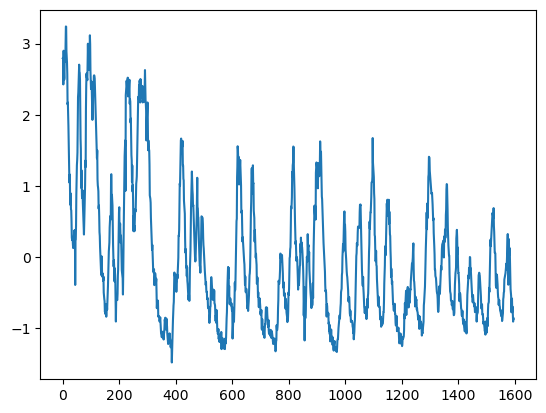

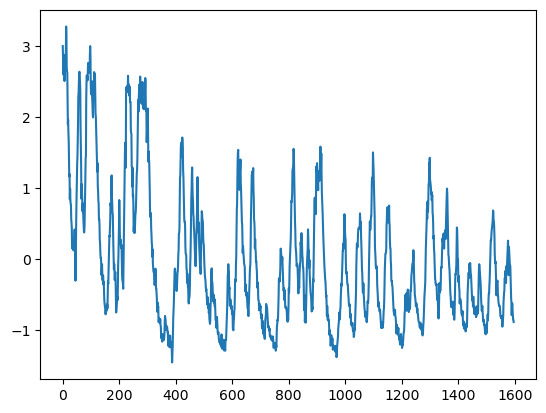

4.953677444013258


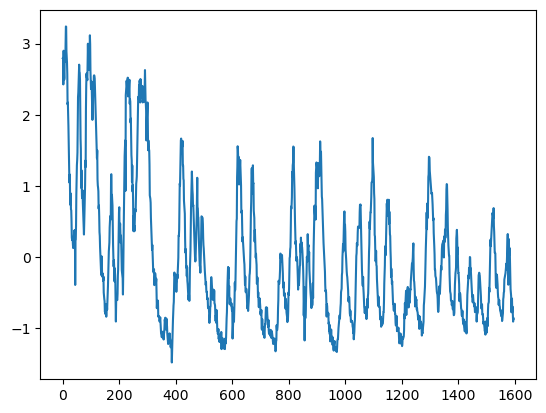

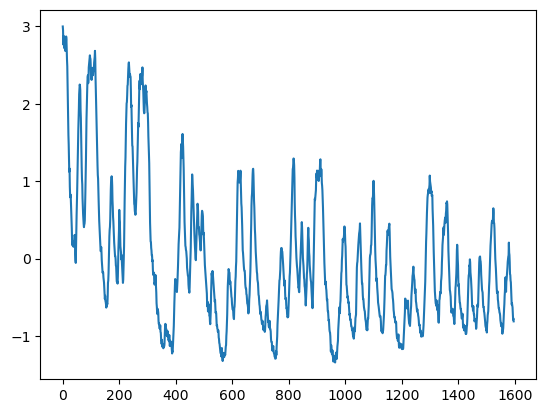

8.372977707284413


In [254]:
trace_obj_1 = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
c_1 = calculate_c(neuron, trace_obj_1, 0, 1600)
live_simulation(c_1, neuron, trace_obj_1)

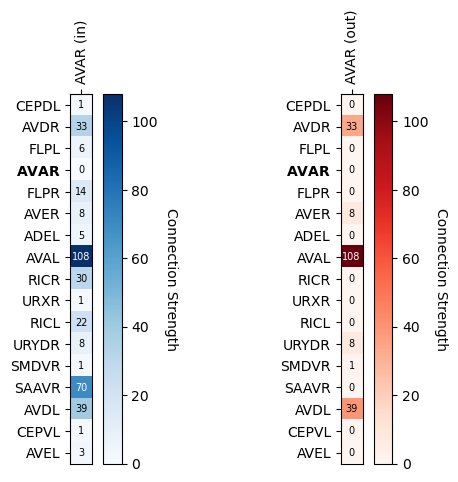

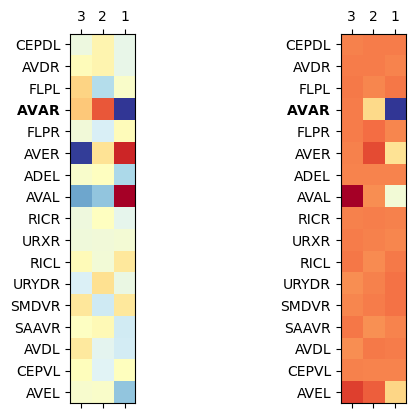

In [255]:
visualize_c(c_1, neuron, trace_obj_1)

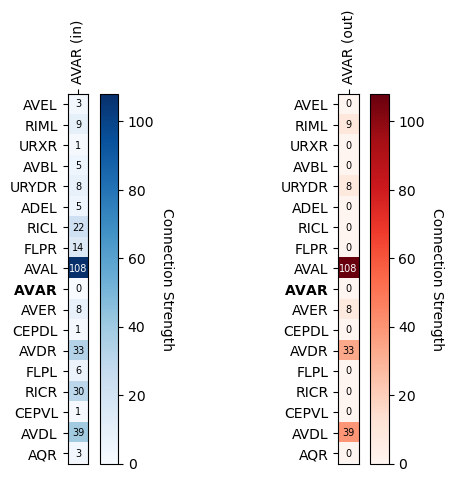

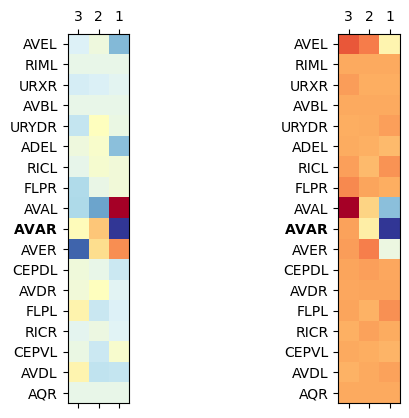

In [256]:
trace_obj_2 = TraceObject('datasets/wormwideweb/2023-01-23-15.json')
c_2 = convert_c(c_1, trace_obj_1, trace_obj_2)
visualize_c(c_2, neuron, trace_obj_2)

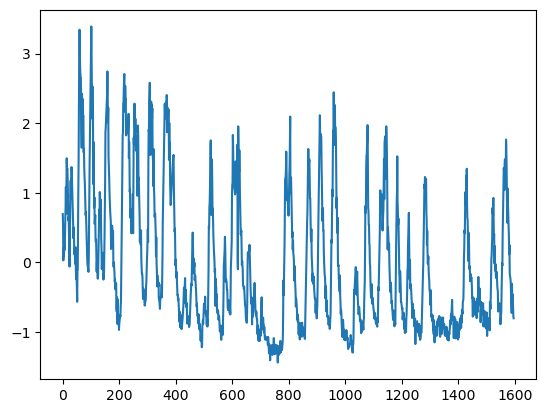

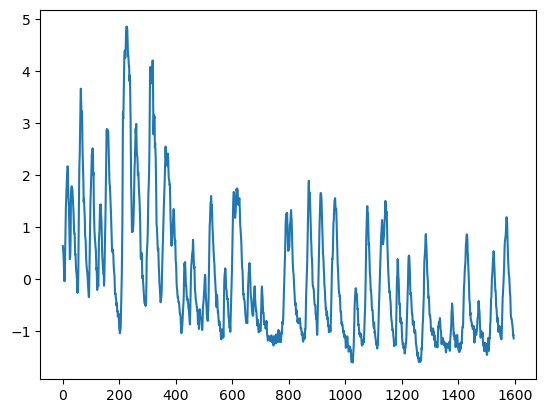

22.09595522399576


In [257]:
live_simulation(c_2, neuron, trace_obj_2)